# Resolving Names of Complexes

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt/)

Often in BEL documents, complexes are named by their members. Additional information might be avaliable from other sources, so these complexes should be resolved to their external names if possible.

In this investigation, the human `9-1-1 Complex` is resolved while other complexes without names are left.

In [1]:
import itertools as itt
import math
import time
import os

import pybel
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pybel.__version__

'0.2.6'

In [3]:
time.asctime()

'Wed Nov 30 13:51:29 2016'

## Prior Knowledge

The OpenBEL Framework provides a listing of named complexes, organized as BEL statements. This can be loaded from URL using PyBEL.

In [4]:
url = 'http://resource.belframework.org/belframework/20150611/resource/named-complexes.bel'
path = os.path.join(pybel.constants.PYBEL_DIR, 'named-complexes.gpickle')

if not os.path.exists(path):
    complexes = pybel.from_url(url)
    pybel.to_pickle(complexes, path)
else:
    complexes = pybel.from_pickle(path)

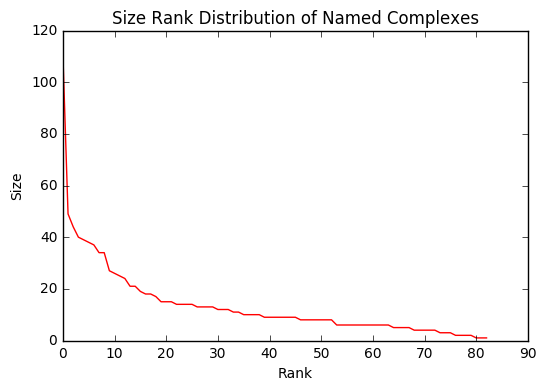

In [5]:
plt.title('Size Rank Distribution of Named Complexes')
plt.xlabel('Rank')
plt.ylabel('Size')
plt.plot(sorted([len(complexes.adj[n]) for n in complexes.nodes_iter(type='Complex')], reverse=True), '-r')
plt.show()

During parsing and compiling, PyBEL transforms each complex into a canonical tuple that consists of the names of each of its members. The prior knowledge graph contains orthologous proteins for each complex, so the members are filtered to match human proteins with `HGNC` identifiers, rather than `MGI` or `RDB`. A mapping is built from the canonical tuple to its name.

In [6]:
# build mapping
t2n = {}
relabel_mapping = {}
for n, d in complexes.nodes_iter(type='Complex', data=True):
    members = complexes.edge[n]
    members = [member for member in members if complexes.node[member]['namespace'] == 'HGNC']
    t = ('Complex',) + tuple(sorted(members))
    t2n[t] = d
    relabel_mapping[t] = n

# Resolution

A test BEL network is parsed and shown before complex name resolution. Here, the `9-1-1 complex` written as `complex(p(HGNC:HUS1), p(HGNC:RAD1), p(HGNC:RAD9A))`

In [7]:
test_bel = """SET DOCUMENT Name = "PyBEL Test Document"
SET DOCUMENT Description = "Made for testing PyBEL parsing"
SET DOCUMENT Version = "1.6"
SET DOCUMENT Copyright = "Copyright (c) Charles Tapley Hoyt. All Rights Reserved."
SET DOCUMENT Authors = "Charles Tapley Hoyt"
SET DOCUMENT Licenses = "Other / Proprietary"
SET DOCUMENT ContactInfo = "charles.hoyt@scai.fraunhofer.de"
DEFINE NAMESPACE ChEBI AS URL "http://resource.belframework.org/belframework/1.0/namespace/chebi-names.belns"
DEFINE NAMESPACE HGNC AS URL "http://resource.belframework.org/belframework/1.0/namespace/hgnc-approved-symbols.belns"
SET Citation = {"Test Source", "Test Title", "123456"}
SET Evidence = "Evidence 1"
complex(p(HGNC:HUS1), p(HGNC:RAD1), p(HGNC:RAD9A)) increases a(ChEBI:"oxygen radical")
complex(p(HGNC:SFN), p(HGNC:YWHAB)) cnc a(ChEBI:"oxygen radical")"""

g = pybel.BELGraph(test_bel.split('\n'))

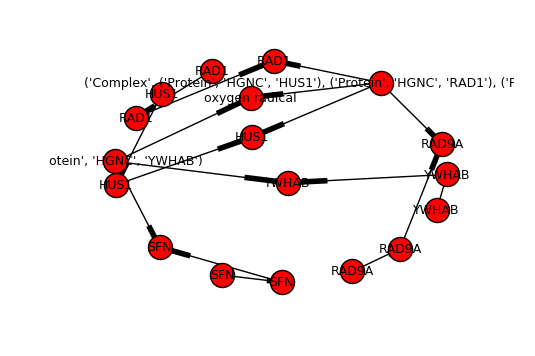

In [8]:
plt.axis('off')
pos = nx.spring_layout(g, iterations=1000)
nx.draw_networkx(g, 
                 pos=pos, 
                 with_labels=True, 
                 nodes=5, 
                 labels={n:('{}'.format(n[2]) if len(n) == 3 else n) for n in g}, 
                 font_size=9)
plt.show()

Finally, the complexes are quickly matched with the mapping dictionary. The appropriate annotations are added, and the node is renamed. The network is shown again with the resolved nodes.

In [9]:
# fix node data
for com in g.nodes_iter(type="Complex"):
    if com in t2n:
        g.node[com].update(t2n[com]) 
        
# fix node names
gr = nx.relabel_nodes(g, lambda n: relabel_mapping[n] if n in relabel_mapping else n, copy=False)

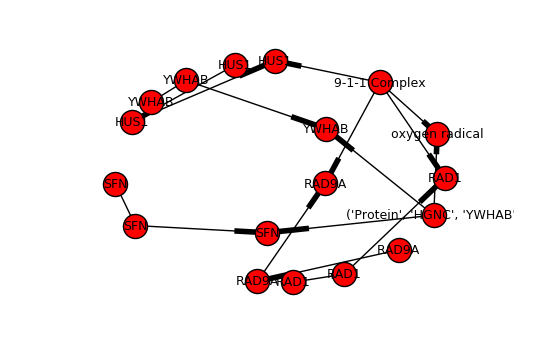

In [10]:
plt.axis('off')
pos = nx.spring_layout(gr, iterations=1000)
nx.draw_networkx(gr, 
                 pos=pos, 
                 with_labels=True, 
                 nodes=5, 
                 labels={n:('{}'.format(n[2]) if len(n) == 3 else n) for n in g}, 
                 font_size=9)
plt.show()

# Conclusions

Resolution of complexes to proper names allows for better semantic integration. In the future, PyBEL will include the process outlined in this notebook as a built-in post-processing tool, using the resources from the OpenBEL Framework eventually from the original sources.